# UNHCR Forcibly Displaced Populations Casptone Project

## Logistic Regression

---


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.metrics import  plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.datasets import make_classification
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn import preprocessing
import warnings

In [58]:
warnings.filterwarnings('ignore')

### Load the data

In [61]:
df = pd.read_csv('/Users/dayosangowawa/Desktop/GA/DSI20-lessons/projects/project-capstone/My Capstone/Forcibly displaced persons - Capstone Dayo Sangowawa/cleaned_unhcrdf_final.csv')
df.head()

,Unnamed: 0,country_of_origin,country_of_asylum,population_type,urban_or_rural_location,accommodation_type,female_aged_0-4 years,female_aged_5-11 years,female_aged_12-17 years,female_aged_18-59 years,female_aged_over_60_years,male_aged_0-4_years,male_aged_5-11_years,male_aged_12-17 years,male_aged_18-59_years,male_aged_over_60_years
0,0,Colombia,Aruba,ASY,Urban,I,0,0,0,0,0,0,0,0,5,0
1,1,Cuba,Aruba,ASY,Urban,I,0,0,0,0,0,0,0,0,0,0
2,2,Afghanistan,Afghanistan,IDP,Rural,I,0,14,16,37,0,0,15,17,38,5
3,3,Afghanistan,Afghanistan,IDP,Urban,Q,74,810,853,2004,140,75,840,921,2278,206
4,4,Afghanistan,Afghanistan,IDP,Urban,Q,12,130,138,321,21,12,135,147,365,33


In [62]:
df.drop(columns = ['Unnamed: 0'], inplace=True)

In [63]:
y = df.pop('accommodation_type')
X = pd.get_dummies(df, drop_first=True)

In [64]:
print('Baseline prediction: ', y.value_counts(normalize=True).max())

Baseline prediction:  0.8497186815375424


In [65]:
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)

In [66]:
y
#'0 'if it is 'I 'and '1' if it is 'other'. 

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [67]:
y = y.ravel()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=1)

In [69]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Lasso Regularization - GridSearch

In [71]:
lr_lasso = LogisticRegression(penalty = 'l1')


In [72]:
params = {'C': np.linspace(1, 2, 10), 
        'solver' :['liblinear', 'saga']}

In [73]:
lr_lasso_gs = GridSearchCV(estimator=lr_lasso, param_grid=params, cv=5)

In [ ]:
lr_lasso_gs.fit(X_train, y_train)

In [ ]:
lr_lasso_gs.best_params_

In [16]:
lr_lasso_best = LogisticRegression(penalty = 'l1', C = 1.0, solver='liblinear')

#lasso

In [17]:
lr_lasso_best.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [18]:
print('Accuracy score - train: ', lr_lasso_best.score(X_train, y_train))
print('Accuracy score - test: ', lr_lasso_best.score(X_test, y_test))
print('Mean CV score - train: ', cross_val_score(lr_lasso_best, X_train, y_train, cv=5).mean())

Accuracy score - train:  0.9148411153455981
Accuracy score - test:  0.9166529582716455
Mean CV score - train:  0.9138677995021084


### Feature Importances

In [19]:
feat_import = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_lasso_best.coef_[0]
})

feat_import.sort_values('Coefficient', ascending=False, inplace=True)
feat_import

,Feature,Coefficient
375,country_of_asylum_Switzerland,2.071261
276,country_of_asylum_France,1.968775
389,country_of_asylum_United Kingdom of Great Brit...,1.379588
339,country_of_asylum_Norway,1.256617
247,country_of_asylum_Canada,1.241415
...,...,...
8,male_aged_18-59_years,-0.305989
7,male_aged_12-17 years,-0.486486
1,female_aged_5-11 years,-0.560360
0,female_aged_0-4 years,-0.791154


In [20]:
feat_import.head(10)

,Feature,Coefficient
375,country_of_asylum_Switzerland,2.071261
276,country_of_asylum_France,1.968775
389,country_of_asylum_United Kingdom of Great Brit...,1.379588
339,country_of_asylum_Norway,1.256617
247,country_of_asylum_Canada,1.241415
228,country_of_asylum_Austria,1.106811
242,country_of_asylum_Bulgaria,1.104343
293,country_of_asylum_Indonesia,1.089789
309,country_of_asylum_Lebanon,1.014584
282,country_of_asylum_Greece,1.006551


In [21]:
feat_import.tail(10)

,Feature,Coefficient
225,country_of_asylum_Argentina,-0.156554
361,country_of_asylum_Sierra Leone,-0.174723
402,population_type_REF,-0.218260
4,female_aged_over_60_years,-0.281879
286,country_of_asylum_Guinea-Bissau,-0.301331
8,male_aged_18-59_years,-0.305989
7,male_aged_12-17 years,-0.486486
1,female_aged_5-11 years,-0.560360
0,female_aged_0-4 years,-0.791154
406,urban_or_rural_location_Urban,-1.874013


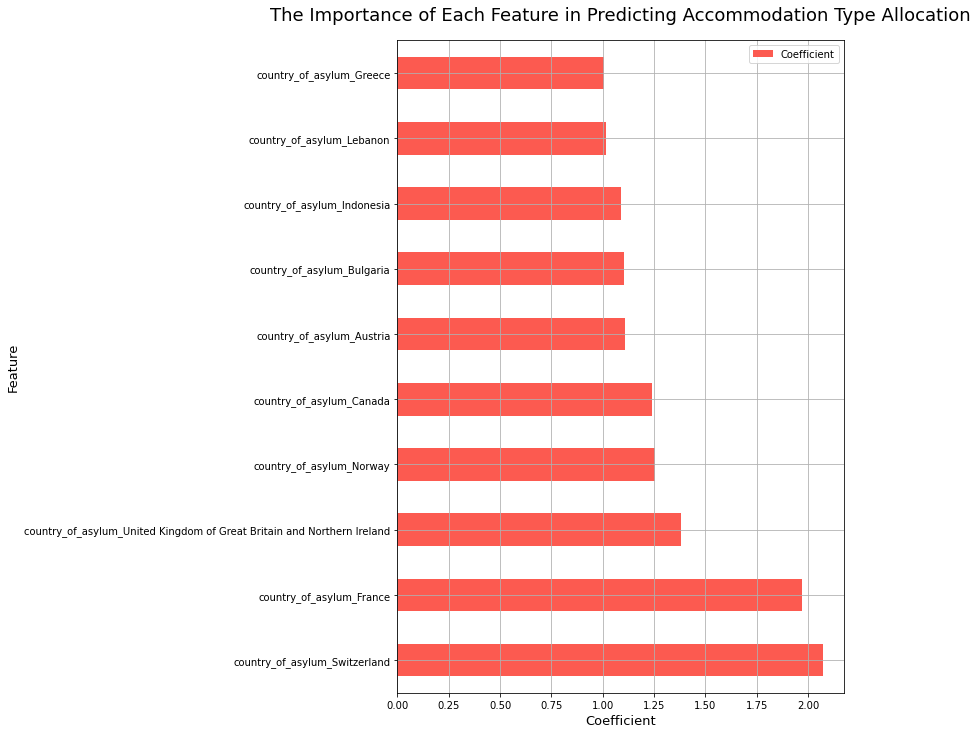

In [22]:
feat_import.head(10).plot(kind='barh', x='Feature', y='Coefficient', figsize=(8, 12), color='#FC5A50')
plt.xlabel('Coefficient', fontsize=13)
plt.ylabel('Feature', fontsize=13)
plt.title('The Importance of Each Feature in Predicting Accommodation Type Allocation', fontsize=18, pad=20)
plt.grid()
plt.show();

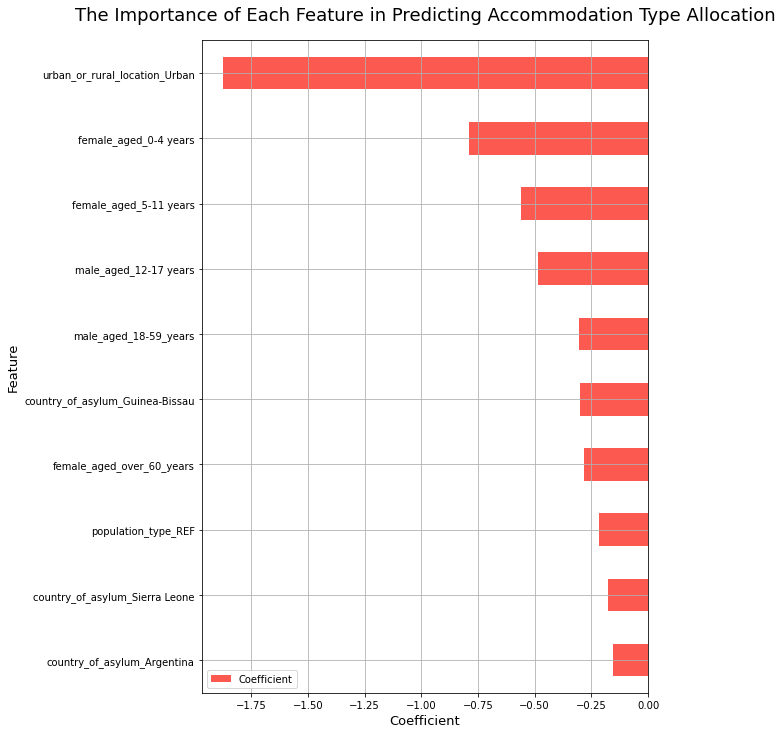

In [23]:
feat_import.tail(10).plot(kind='barh', x='Feature', y='Coefficient', figsize=(8, 12), color='#FC5A50')
plt.xlabel('Coefficient', fontsize=13)
plt.ylabel('Feature', fontsize=13)
plt.title('The Importance of Each Feature in Predicting Accommodation Type Allocation', fontsize=18, pad=20)
plt.grid()
plt.show();

### Evaluation

In [24]:
import scikitplot as skplt

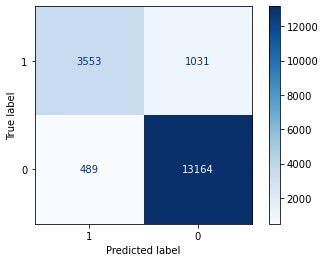

In [25]:
plot_confusion_matrix(lr_lasso_best, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

In [26]:
y_test_pred_lasso = lr_lasso_best.predict(X_test)

In [27]:
print(classification_report(y_test, y_test_pred_lasso))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     13653
           1       0.88      0.78      0.82      4584

    accuracy                           0.92     18237
   macro avg       0.90      0.87      0.88     18237
weighted avg       0.92      0.92      0.91     18237



In [28]:
print(f1_score(y_test, y_test_pred_lasso))

0.8237885462555066


In [29]:
probabilities_train_lasso = lr_lasso_best.predict_proba(X_train)

In [30]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(lr_lasso_best.classes_)))

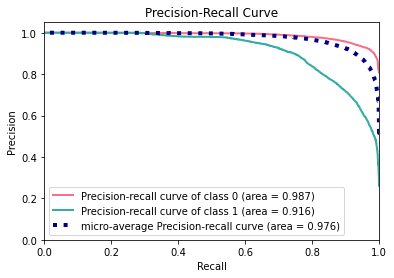

In [31]:
skplt.metrics.plot_precision_recall(y_train, probabilities_train_lasso, cmap=cmap)
plt.show()

In [32]:
print('Average precision score: ', average_precision_score(y_train, probabilities_train_lasso[:, 1]))

Average precision score:  0.9158141944054354


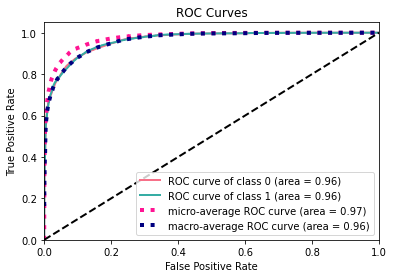

In [33]:
skplt.metrics.plot_roc(y_train, probabilities_train_lasso, cmap=cmap)
plt.show()

In [34]:
print('Area under the curve : ', roc_auc_score(y_train, probabilities_train_lasso[:, 1]))

Area under the curve :  0.9633274283807791


### Ridge Regularization - GridSearch

In [37]:
lr_ridge = LogisticRegression(penalty='l2')

In [38]:
params = {'C': np.linspace(1, 2, 10), 
        'solver' :['lbfgs', 'newton-cg', 'sag']}

In [ ]:
lr_ridge_gs = GridSearchCV(estimator=lr_ridge, param_grid=params, cv=5)

In [ ]:
lr_ridge_gs.fit(X_train, y_train)

In [ ]:
lr_ridge_gs.best_params_

In [ ]:
lr_ridge_gs.best_score_

In [39]:
lr_ridge = LogisticRegression(penalty='l2', C = 1.0, solver = 'newton-cg')

In [40]:
lr_ridge.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [42]:
print('Accuracy score - train: ', lr_ridge.score(X_train, y_train))
print('Accuracy score - test: ', lr_ridge.score(X_test, y_test))
print('Mean CV score - train: ', cross_val_score(lr_ridge, X_train, y_train, cv=5).mean())

Accuracy score - train:  0.9148685328873413
Accuracy score - test:  0.9165981246915611
Mean CV score - train:  0.913895216480104


### Evaluation

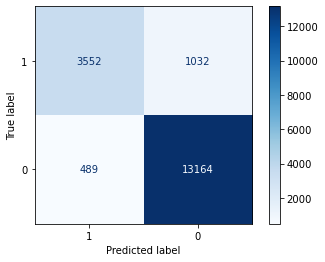

In [43]:
plot_confusion_matrix(lr_ridge, X_test, y_test, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

In [45]:
y_test_pred_ridge = lr_ridge.predict(X_test)

In [46]:
print(classification_report(y_test, y_test_pred_ridge))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     13653
           1       0.88      0.77      0.82      4584

    accuracy                           0.92     18237
   macro avg       0.90      0.87      0.88     18237
weighted avg       0.92      0.92      0.91     18237



In [47]:
print(f1_score(y_test, y_test_pred_ridge))

0.8236521739130436


In [48]:
probabilities_train_ridge = lr_ridge.predict_proba(X_train)

In [49]:
cmap = ListedColormap(sns.color_palette("husl", len(lr_ridge.classes_)))

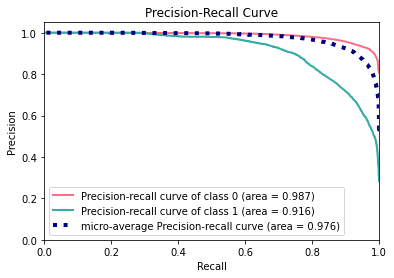

In [50]:
skplt.metrics.plot_precision_recall(y_train, probabilities_train_ridge, cmap=cmap)
plt.show()

In [51]:
print('Average precision score: ', average_precision_score(y_train, probabilities_train_ridge[:, 1]))

Average precision score:  0.9158550069682073


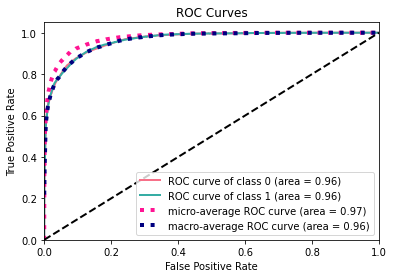

In [52]:
skplt.metrics.plot_roc(y_train, probabilities_train_ridge, cmap=cmap)
plt.show()

In [54]:
print('Area under the curve: ', roc_auc_score(y_train, probabilities_train_ridge[:, 1]))

Area under the curve :  0.9633526119128724


In [ ]:
######Elastic net#######

In [ ]:
lr_en = LogisticRegression(penalty = 'elasticnet', solver='saga')


In [ ]:
params = {'C': np.linspace(1, 2, 10), 'l1_ratio' : range(0, 1)}

In [ ]:
lr_en_gs = GridSearchCV(estimator=lr_en, param_grid=params, cv=5)

In [ ]:
lr_en_gs.fit(X_train, y_train)

In [ ]:
lr_en_gs.best_params_

In [ ]:
lr_en_gs.best_score_

In [55]:
lr_en_best = LogisticRegression(penalty='elasticnet', C = 1.7777777777777777, solver = 'saga', l1_ratio=0)

In [56]:
lr_en_best.fit(X_train, y_train)

LogisticRegression(C=1.7777777777777777, l1_ratio=0, penalty='elasticnet',
                   solver='saga')

In [ ]:
print('Accuracy score - train: ', lr_en_best.score(X_train, y_train))
print('Accuracy score - test: ', lr_en_best.score(X_test, y_test))
print('Mean CV score - train: ', cross_val_score(lr_en_best, X_train, y_train, cv=5).mean())